In [1]:
from PIL import Image, ImageFilter
#import tensorflow as tf
#from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import cv2
import csv

import shiny_data


In [2]:
def train_resnet50(train_dataset, val_dataset, batch_size=128, num_epochs=10, augmentation="original"):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size)

    # Train model with no augmentations
    #tf.keras.backend.clear_session()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=True)

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    # Replace final layer for 4 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    losses = []
    accuracies = []

    patience = 5  # number of epochs to wait for improvement
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Accuracy calculation
            _, predicted = outputs.max(1)  # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, predicted = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += (predicted == val_labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'resnet50_models/resnet50_{augmentation}_model.pt')  # save the best model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered!")
                early_stop = True
                break

    # Load and save the best model
    if not early_stop:
        print("Training completed without early stopping.")

    return losses, accuracies

In [5]:
def cont_train_resnet50(train_dataset, val_dataset, losses, accuracies, batch_size=128, num_epochs=10, augmentation="original"):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size)

    # Train model with no augmentations
    #tf.keras.backend.clear_session()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=False)

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    # Replace final layer for 4 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)

    model.load_state_dict(torch.load(f'resnet50_models/resnet50_original_model.pt', map_location=device))  # Load first
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    losses = losses
    accuracies = accuracies

    patience = 5  # number of epochs to wait for improvement
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Accuracy calculation
            _, predicted = outputs.max(1)  # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, predicted = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += (predicted == val_labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'resnet50_models/resnet50_{augmentation}_model.pt')  # save the best model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered!")
                early_stop = True
                break

    # Load and save the best model
    if not early_stop:
        print("Training completed without early stopping.")

    return losses, accuracies

In [7]:
# Function to evaluate model
def eval_resnet50(test_dataset, batch_size=128, augmentation="original", blur_level=0, contrast_level=1, log_path="resnet50.csv"):
    test_loader = DataLoader(test_dataset, batch_size)

    model = models.resnet50(pretrained=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Reset model parameters to load in existing weights
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, 4)
    model.load_state_dict(torch.load(f'resnet50_models/resnet50_original_model.pt', map_location=device))  # Load first
    model = model.to(device)

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []


    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Pick class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = 100 * correct / total
    f1_total = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    
    # Get class-specific precision — assumes order is [0: Tumour, 1: Immune, 2: Stromal, 3: Other]
    precision_tumour = report.get('0', {}).get('precision', 0.0)
    precision_immune = report.get('1', {}).get('precision', 0.0)
    precision_stromal = report.get('2', {}).get('precision', 0.0)
    precision_other = report.get('3', {}).get('precision', 0.0)

    f1_tumour = report.get('0', {}).get('f1-score', 0.0)
    f1_immune = report.get('1', {}).get('f1-score', 0.0)
    f1_stromal = report.get('2', {}).get('f1-score', 0.0)
    f1_other = report.get('3', {}).get('f1-score', 0.0)

    print(f"Original Accuracy: {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds))

    # Write to CSV
    
    row = ["resnet50_" + augmentation, blur_level, contrast_level, accuracy,
           precision_tumour, precision_immune, precision_stromal, precision_other, f1_total, f1_tumour, f1_immune, f1_stromal, f1_other, recall]

    write_header = not os.path.exists(log_path)

    with open(log_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

    return accuracy, f1_total, precision, recall


def graph_loss_accuracy(losses, accuracies, num_epochs):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), losses, label='Loss')
    plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Loss and Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
log_path="resnet50.csv"
header = ["Model", "blur_level", "contrast_level", "Accuracy", 
              "Precision_tumour", "Precision_immune", "Precision_stromal", "Precision_other", "f1_overall", "f1_tumour", "f1_immune", "f1_stromal", "f1_other", "recall"]
with open(log_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)


In [58]:
num_epochs = 20
batch_size = 64

train_dataset, val_dataset, test_dataset = shiny_data.get_original()
losses, accuracies = cont_train_resnet50(train_dataset, val_dataset, losses, accuracies, batch_size, num_epochs, augmentation="original")

Tumour images loaded
Tumour: loaded 4000 images
Immune images loaded
Immune: loaded 4000 images
Stromal images loaded
Stromal: loaded 4000 images
Other images loaded
Other: loaded 4000 images
[('Immune', 0), ('Other', 1), ('Stromal', 2), ('Tumour', 3)]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 0.7239, Accuracy: 0.7210
Validation Loss: 0.8417, Validation Accuracy: 0.6860
Epoch 2, Loss: 0.7192, Accuracy: 0.7242
Validation Loss: 0.8244, Validation Accuracy: 0.6785
Epoch 3, Loss: 0.7323, Accuracy: 0.7142
Validation Loss: 0.8158, Validation Accuracy: 0.6900
Epoch 4, Loss: 0.7212, Accuracy: 0.7220
Validation Loss: 0.8503, Validation Accuracy: 0.6995
Epoch 5, Loss: 0.7083, Accuracy: 0.7273
Validation Loss: 0.8226, Validation Accuracy: 0.6960
Epoch 6, Loss: 0.7188, Accuracy: 0.7201
Validation Loss: 0.8429, Validation Accuracy: 0.6900
Epoch 7, Loss: 0.7112, Accuracy: 0.7284
Validation Loss: 0.8574, Validation Accuracy: 0.6855
Epoch 8, Loss: 0.6980, Accuracy: 0.7263
Validation Loss: 0.8403, Validation Accuracy: 0.6875
Early stopping triggered!


In [8]:
losses, accuracies = train_resnet50(train_dataset, val_dataset, batch_size, num_epochs, augmentation="original")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.9621, Accuracy: 0.6068
Validation Loss: 0.9081, Validation Accuracy: 0.6380
Epoch 2, Loss: 0.8428, Accuracy: 0.6711
Validation Loss: 0.8804, Validation Accuracy: 0.6515
Epoch 3, Loss: 0.8143, Accuracy: 0.6839
Validation Loss: 0.8951, Validation Accuracy: 0.6685
Epoch 4, Loss: 0.7960, Accuracy: 0.6891
Validation Loss: 0.8568, Validation Accuracy: 0.6615
Epoch 5, Loss: 0.7960, Accuracy: 0.6851
Validation Loss: 0.8648, Validation Accuracy: 0.6655
Epoch 6, Loss: 0.7781, Accuracy: 0.6977
Validation Loss: 0.8601, Validation Accuracy: 0.6630
Epoch 7, Loss: 0.7801, Accuracy: 0.6961
Validation Loss: 0.8569, Validation Accuracy: 0.6515
Epoch 8, Loss: 0.7835, Accuracy: 0.6968
Validation Loss: 0.8362, Validation Accuracy: 0.6835
Epoch 9, Loss: 0.7558, Accuracy: 0.7064
Validation Loss: 0.8729, Validation Accuracy: 0.6605
Epoch 10, Loss: 0.7553, Accuracy: 0.7085
Validation Loss: 0.8407, Validation Accuracy: 0.6760
Epoch 11, Loss: 0.7542, Accuracy: 0.7081
Validation Loss: 0.8349, Val

In [ ]:
# Original data

og_accuracy, og_f1, og_precision, og_recall = eval_resnet50(test_dataset, batch_size, augmentation="original")

print(f"Original Accuracy: {og_accuracy:.2f}%")
print(f"Original F1 Score: {og_f1:.2f}")
print(f"Original Precision: {og_precision:.2f}")
print(f"Original Recall: {og_recall:.2f}")

graph_loss_accuracy(losses, accuracies, num_epochs)


In [21]:
# Data to augment
#graph_loss_accuracy(losses, accuracies, num_epochs)

num_epochs = 20
batch_size = 64


Xmat_train, Xmat_val, Xmat_test, y_train_enc, y_val_enc, y_test_enc = shiny_data.load_split_images(2500, 500, 1000)

blur_levels = [0,1,3,5,7,10]
contrast_levels = [1,1.25,1.5,1.75,2]

for blur in blur_levels:
    for contrast in contrast_levels:

        augmentation = f"blur{blur}_contrast{contrast}"

        # Augment data
        Xmat_test_blurred = shiny_data.apply_blur(Xmat_test, blur)
        Xmat_test_augmented = shiny_data.adjust_contrast(Xmat_test_blurred, contrast)

        train_dataset, val_dataset, test_dataset = shiny_data.transform_datasets(Xmat_train, Xmat_val, Xmat_test_augmented, y_train_enc, y_val_enc, y_test_enc)
        accuracy, f1, precision, recall = eval_resnet50(test_dataset, batch_size, augmentation, blur, contrast)

        print(f"Augmentation: {augmentation}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"F1 Score: {f1:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")

Tumour images loaded
Tumour: loaded 4000 images
Immune images loaded
Immune: loaded 4000 images
Stromal images loaded
Stromal: loaded 4000 images
Other images loaded
Other: loaded 4000 images
[('Immune', 0), ('Other', 1), ('Stromal', 2), ('Tumour', 3)]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Original Accuracy: 69.17%
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1000
           1       0.73      0.71      0.72      1000
           2       0.64      0.57      0.61      1000
           3       0.73      0.85      0.78      1000

    accuracy                           0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.69      0.69      0.69      4000



NameError: name 'f1' is not defined

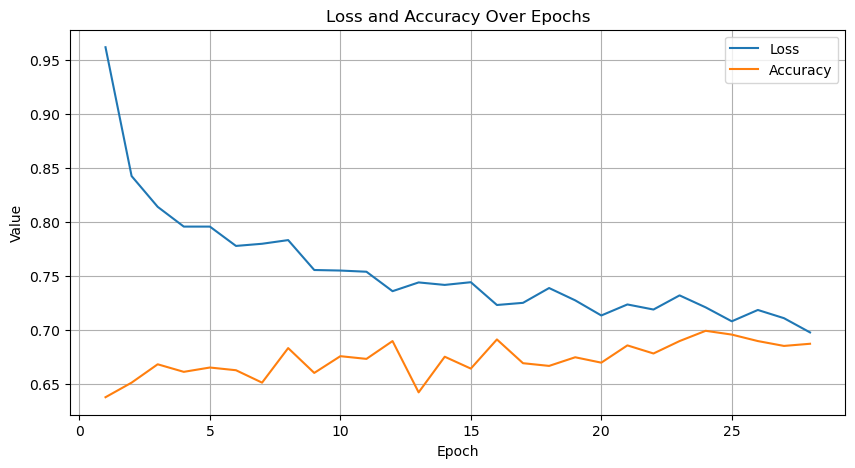

In [26]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

with open("train_val.txt", "r") as f:
    lines = f.readlines()

num_epochs = len(lines)//2

for i in range(0, len(lines), 2):
    # Parse training line
    train_line = lines[i].strip()
    parts = train_line.split(", ")
    loss_part = parts[1].split(": ")[1]
    acc_part = parts[2].split(": ")[1]
    train_loss.append(float(loss_part))
    train_acc.append(float(acc_part))

    # Parse validation line
    val_line = lines[i+1].strip()
    val_parts = val_line.split(", ")
    val_loss_part = val_parts[0].split(": ")[1]
    val_acc_part = val_parts[1].split(": ")[1]
    val_loss.append(float(val_loss_part))
    val_acc.append(float(val_acc_part))


graph_loss_accuracy(train_loss, val_acc, num_epochs)

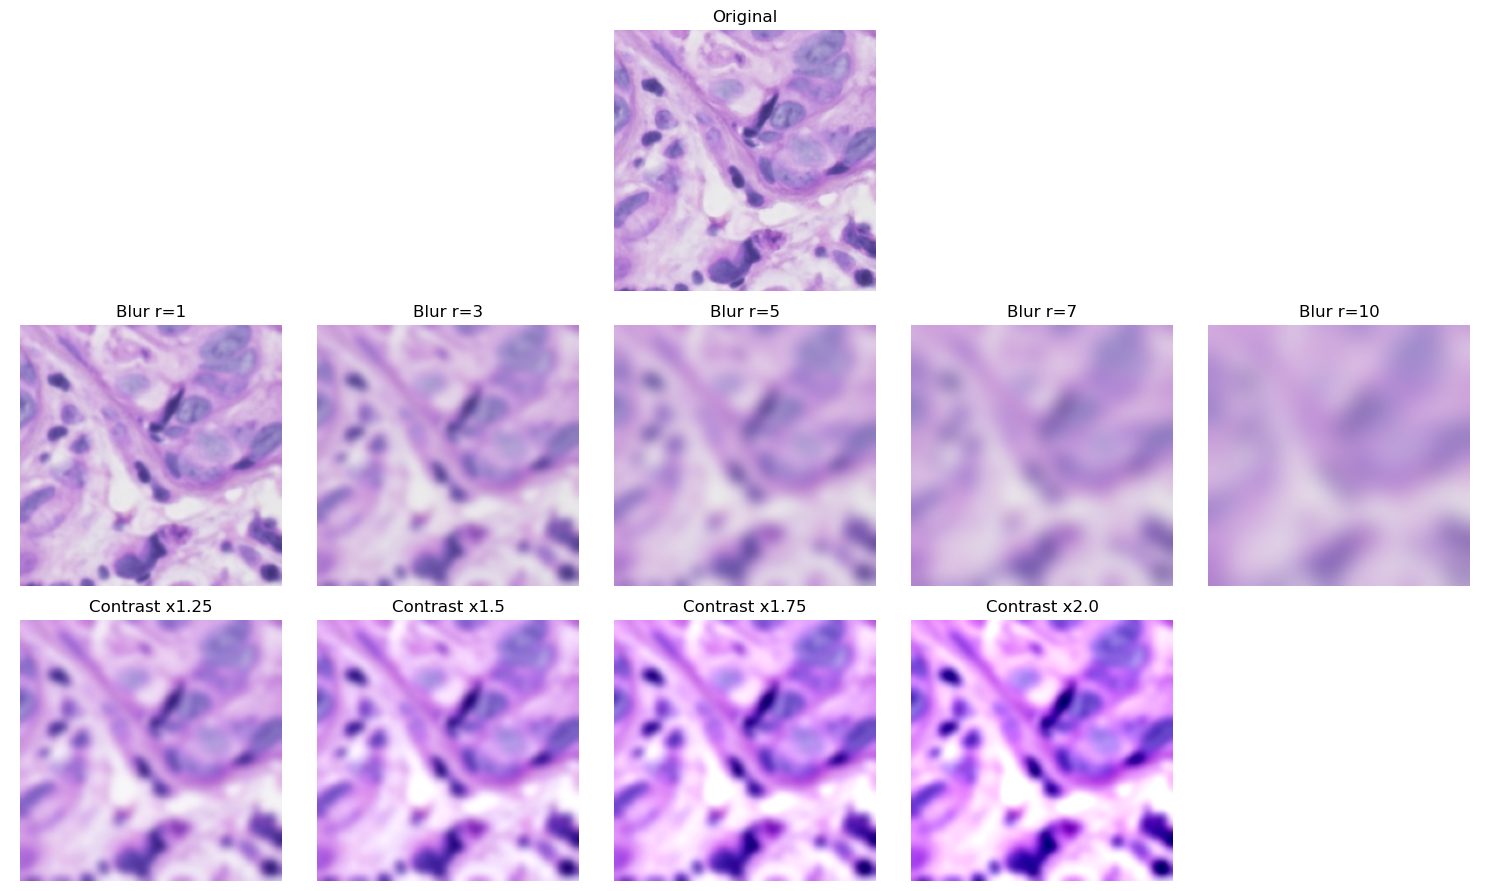

In [56]:
sample_img = Xmat_test[0]  # or any other image in NumPy format

# Define blur and contrast levels
blur_radii = [1, 3, 5, 7, 10]
contrast_factors = [1.25, 1.5, 1.75, 2.0]

# Apply blur variations
blurred_images = [shiny_data.apply_blur([sample_img], size=r)[0] for r in blur_radii]

# Apply contrast variations to image blurred with radius=5
base_blurred = shiny_data.apply_blur([sample_img], size=3)[0]
contrasted_images = [shiny_data.adjust_contrast([base_blurred], factor=f)[0] for f in contrast_factors]

# Create figure: 3 rows, max 5 columns
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Row 1: Original image (centered)
for ax in axes[0]:
    ax.axis('off')
axes[0][2].imshow(sample_img.astype(np.uint8))
axes[0][2].set_title("Original")

# Row 2: Blurred images
for i, (radius, img) in enumerate(zip(blur_radii, blurred_images)):
    axes[1][i].imshow(img.astype(np.uint8))
    axes[1][i].set_title(f"Blur r={radius}")
    axes[1][i].axis('off')

# Row 3: Contrast-enhanced blurred images
for i, (factor, img) in enumerate(zip(contrast_factors, contrasted_images)):
    axes[2][i].imshow(img.astype(np.uint8))
    axes[2][i].set_title(f"Contrast x{factor}")
    axes[2][i].axis('off')

# Hide any unused axes
if len(blur_radii) < 5:
    for ax in axes[1][len(blur_radii):]:
        ax.axis('off')
if len(contrast_factors) < 5:
    for ax in axes[2][len(contrast_factors):]:
        ax.axis('off')

plt.tight_layout()
plt.show()